# Fragility Comparison Analysis

This notebook generates comparison plots across different fragility levels:
- Success Rate vs Position Noise (2×2 grid)
- Break Rate vs Position Noise (2×2 grid with N/A for unbreakable)
- Gold highlight box around the reference fragility level

In [42]:
# ============================================================
# BLOCK 1: IMPORTS & LOCAL CONFIGURATION
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Import shared utilities
from analysis_utils import (
    # Constants
    ENTITY, PROJECT, COLORS,
    TAG_EVAL_PERFORMANCE, TAG_EVAL_NOISE, TAG_OLD_NOISE_EVAL,
    METRIC_SUCCESS, METRIC_BREAKS, METRIC_TOTAL,
    # Data functions
    get_best_checkpoint_per_run,
    download_eval_data,
    # Plotting functions
    plot_multi_panel_grid,
    print_data_summary,
)

# ============================================================
# LOCAL CONFIGURATION (specific to this analysis)
# ============================================================

# Fragility Levels - keys are internal names, each contains method tags
FRAGILITY_LEVELS = {
    #Z-Contact Included
    #"10N": {
    #    "Pose(1mm)": "pose_perf-comp:2026-01-05_10:54",
    #    "Pose(2.5mm)": "pose_25mm-noise:2026-01-19_07:50",
    #    "MATCH(1mm)": "LCLoP_fix_perf-comp:2026-01-09_11:17",
    #    "Hybrid-Basic(1mm)": "basic-hybrid_perf-comp:2026-01-05_10:54",
    #},
    #"15N": {
    #    "Pose(1mm)": "pose_task_frag:2026-01-06_00:52",
    #    "Pose(2.5mm)": "pose_25mm-noise:2026-01-19_07:50_15N",
    #    "MATCH(1mm)": "LCLoP_task_frag:2026-01-06_00:27",
    #    "Hybrid-Basic(1mm)": "basic-hybrid_task_frag:2026-01-06_00:56",
    #},
    #"20N": {
    #    "Pose(1mm)": "pose_task_frag:2026-01-06_00:09",
    #    "Pose(2.5mm)": "pose_25mm-noise:2026-01-19_07:50_20N",
    #    "MATCH(1mm)": "LCLoP_task_frag:2026-01-06_00:09",
    #    "Hybrid-Basic(1mm)": "basic-hybrid_task_frag:2026-01-06_09:18",
    #},
    #"10000N": {
    #    "Pose(1mm)": "pose_task_frag:2026-01-05_23:37",
    #    "Pose(2.5mm)": "pose_25mm-noise:2026-01-19_07:50_unbreak",
    #    "MATCH(1mm)": "LCLoP_task_frag:2026-01-05_22:12",
    #    "Hybrid-Basic(1mm)": "basic-hybrid_task_frag:2026-01-06_00:08",
    #}, """


    "10N": {
        "Pose(1mm)": "pose_breakable_f10N:2026-02-04_17:49",
        #"Pose(2.5mm)": "",
        "MATCH(1mm)": "MATCH_breakable_10N:2026-02-04_17:49",
        "Hybrid-Basic(1mm)": "basic-hybrid_breakable_f10N:2026-02-04_17:49",
    },
    "15N": {
        "Pose(1mm)": "pose_breakable_f15N:2026-02-02_13:41",
        #"Pose(2.5mm)": "",
        "MATCH(1mm)": "MATCH_breakable_f15N:2026-02-02_13:41",
        "Hybrid-Basic(1mm)": "basic-hybrid_breakable_f15N:2026-02-02_13:41",
    },
    "20N": {
        "Pose(1mm)": "pose_breakable_f20N:2026-02-02_13:41",
        #"Pose(2.5mm)": "",
        "MATCH(1mm)": "MATCH_breakable_f20N:2026-02-02_13:41",
        "Hybrid-Basic(1mm)": "basic-hybrid_breakable_f20N:2026-02-02_13:41",
    },
    "10000N": {
        "Pose(1mm)": "pose_base-case:2026-02-02_13:40",
        #"Pose(2.5mm)": "pose_25mm:2026-02-02_13:40",
        "MATCH(1mm)": "MATCH_base-case:2026-02-04_17:46",
        "Hybrid-Basic(1mm)": "basic-hybrid_base-case:2026-02-02_13:40",
    }
}

# Display name mapping
FRAGILITY_DISPLAY_NAMES = {
    "5N": "$F_{th}$ = 5N",
    "10N": "$F_{th}$ = 10N",
    "15N": "$F_{th}$ = 15N",
    "20N": "$F_{th}$ = 20N",
    "10000N": "Unbreakable",
}

# Noise Level Mapping: display label -> metric range string
NOISE_LEVELS = {
    "1mm": "0mm-1mm",
    "2.5mm": "1mm-2.5mm",
    "5mm": "2.5mm-5mm",
    "7.5mm": "5mm-7.5mm",
}

# Old Noise Eval Filter: None, "include", or "exclude"
OLD_NOISE_EVAL_FILTER = "exclude"

# Policy Selection
TOP_N_POLICIES = None
MAX_CHECKPOINT = None  # Set to int to limit checkpoint search (e.g., 2000000 for first 2M steps)

# Highlight Configuration
HIGHLIGHT_FRAGILITY = "10000N"  # Which fragility to highlight with gold box, or None

# N/A panels (where break rate is not applicable)
NA_FRAGILITIES = ["10000N"]

# Plot Configuration
SUCCESS_Y_LIM = (0, 100)
SUCCESS_Y_TICKS = [0, 20, 40, 60, 80, 100]
BREAK_Y_LIM = (0, 7)
BREAK_Y_TICKS = list(range(7))

# Error type: "ci" for 95% confidence interval, "binary_se" for binary standard error
ERROR_TYPE = "ci"

In [43]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

api = wandb.Api()
best_checkpoints = defaultdict(dict)  # best_checkpoints[fragility][method]

for fragility, method_tags in FRAGILITY_LEVELS.items():
    print(f"\n{'='*60}")
    print(f"Fragility: {fragility}")
    print(f"{'='*60}")
    for method_name, method_tag in method_tags.items():
        print(f"\n  {method_name} ({method_tag}):")
        best_checkpoints[fragility][method_name] = get_best_checkpoint_per_run(
            api, method_tag, max_checkpoint=MAX_CHECKPOINT
        )


Fragility: 10N

  Pose(1mm) (pose_breakable_f10N:2026-02-04_17:49):
  Eval_performance_pose_breakable_f(10)_0: best checkpoint at step 2188800 (score: 93)
  Eval_performance_pose_breakable_f(10)_1: best checkpoint at step 1804800 (score: 91)
  Eval_performance_pose_breakable_f(10)_2: best checkpoint at step 1843200 (score: 92)
  Eval_performance_pose_breakable_f(10)_3: best checkpoint at step 2419200 (score: 92)
  Eval_performance_pose_breakable_f(10)_4: best checkpoint at step 38400 (score: 0)

  MATCH(1mm) (MATCH_breakable_10N:2026-02-04_17:49):
  Eval_performance_MATCH_breakable_f(10)_0: best checkpoint at step 1075200 (score: 95)
  Eval_performance_MATCH_breakable_f(10)_1: best checkpoint at step 1651200 (score: 97)
  Eval_performance_MATCH_breakable_f(10)_2: best checkpoint at step 2265600 (score: 97)
  Eval_performance_MATCH_breakable_f(10)_3: best checkpoint at step 1497600 (score: 82)
  Eval_performance_MATCH_breakable_f(10)_4: best checkpoint at step 2073600 (score: 94)

  Hy

In [44]:
# ============================================================
# BLOCK 3: DOWNLOAD DATA
# ============================================================

print(f"Old Noise Eval Filter: {OLD_NOISE_EVAL_FILTER}")

noise_data = defaultdict(dict)  # noise_data[fragility][method]

for fragility, method_tags in FRAGILITY_LEVELS.items():
    print(f"\n{'='*60}")
    print(f"Downloading data for Fragility: {fragility}")
    print(f"{'='*60}")
    for method_name, method_tag in method_tags.items():
        print(f"\n  {method_name}...")
        noise_data[fragility][method_name] = download_eval_data(
            api=api,
            method_tag=method_tag,
            best_checkpoints=best_checkpoints[fragility][method_name],
            level_mapping=NOISE_LEVELS,
            prefix_template="Noise_Eval({level})_Core",
            level_col_name="noise_level",
            eval_tag=TAG_EVAL_NOISE,
            old_noise_filter=OLD_NOISE_EVAL_FILTER,
        )

# Print summary
print("\n" + "="*60)
print("DATA SUMMARY")
print("="*60)
for fragility in FRAGILITY_LEVELS.keys():
    print(f"\n{fragility}:")
    for method_name in FRAGILITY_LEVELS[fragility].keys():
        df = noise_data[fragility][method_name]
        if not df.empty:
            num_runs = df["run_name"].nunique()
            print(f"  {method_name}: {num_runs} runs")
        else:
            print(f"  {method_name}: No data")

Old Noise Eval Filter: exclude


  Pose(1mm)...

  MATCH(1mm)...

  Hybrid-Basic(1mm)...


  Pose(1mm)...

  MATCH(1mm)...

  Hybrid-Basic(1mm)...


  Pose(1mm)...

  MATCH(1mm)...

  Hybrid-Basic(1mm)...


  Pose(1mm)...

  MATCH(1mm)...

  Hybrid-Basic(1mm)...

DATA SUMMARY

10N:
  Pose(1mm): 5 runs
  MATCH(1mm): 5 runs
  Hybrid-Basic(1mm): 5 runs

15N:
  Pose(1mm): 5 runs
  MATCH(1mm): 5 runs
  Hybrid-Basic(1mm): 5 runs

20N:
  Pose(1mm): 5 runs
  MATCH(1mm): 5 runs
  Hybrid-Basic(1mm): 5 runs

10000N:
  Pose(1mm): 5 runs
  MATCH(1mm): 5 runs
  Hybrid-Basic(1mm): 5 runs


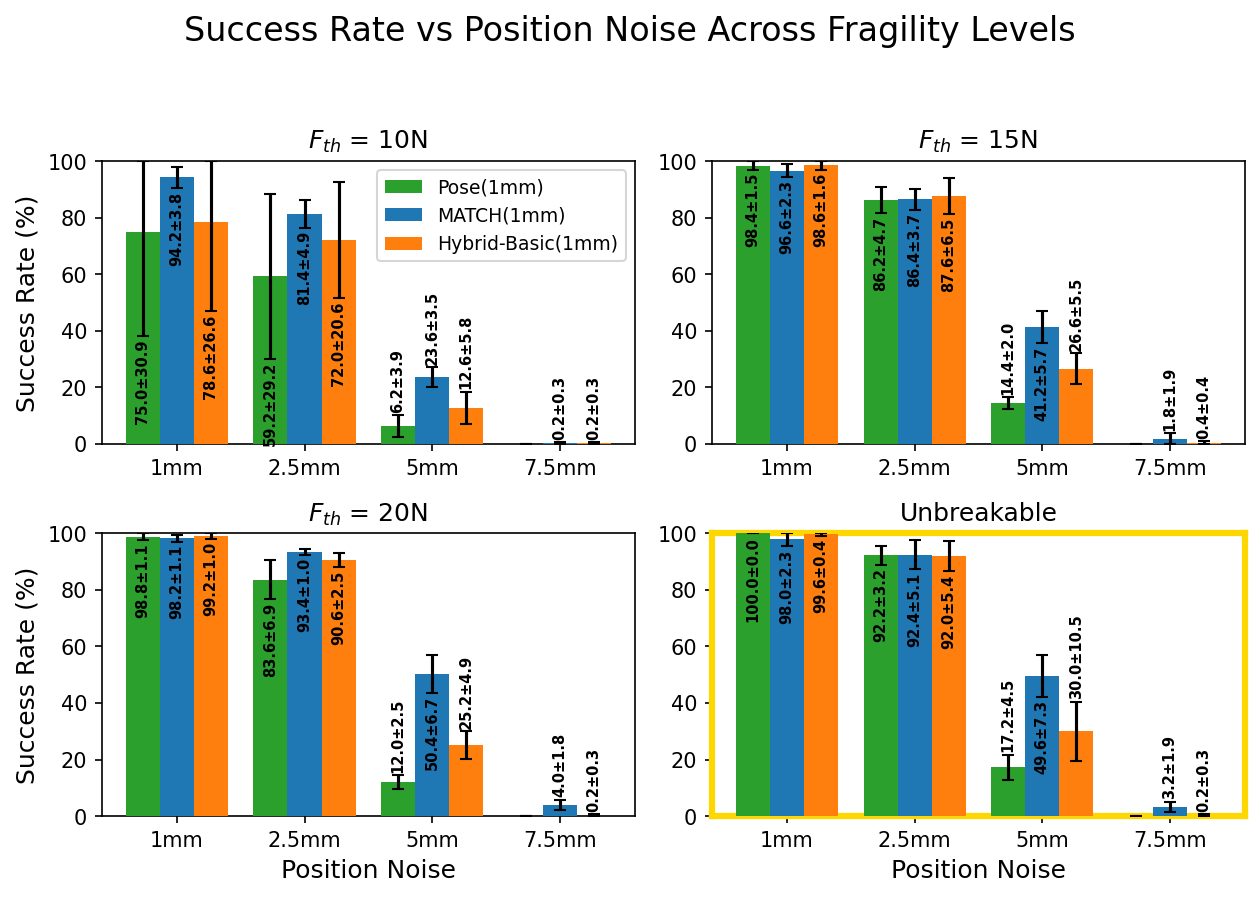

In [45]:
# ============================================================
# BLOCK 4: SUCCESS RATE COMPARISON FIGURE
# ============================================================

# Get method names from first fragility level
method_names = list(FRAGILITY_LEVELS[list(FRAGILITY_LEVELS.keys())[0]].keys())

fig, axes = plot_multi_panel_grid(
    data=dict(noise_data),
    panel_keys=list(FRAGILITY_LEVELS.keys()),
    panel_display_names=FRAGILITY_DISPLAY_NAMES,
    method_names=method_names,
    level_labels=list(NOISE_LEVELS.keys()),
    level_col="noise_level",
    metric="success",
    n_cols=2,
    suptitle="Success Rate vs Position Noise Across Fragility Levels",
    x_label="Position Noise",
    y_label="Success Rate (%)",
    y_lim=SUCCESS_Y_LIM,
    y_ticks=SUCCESS_Y_TICKS,
    error_type=ERROR_TYPE,
    highlight_panel=HIGHLIGHT_FRAGILITY,
    filter_top_n=TOP_N_POLICIES,
    best_checkpoints=dict(best_checkpoints),
)
plt.show()

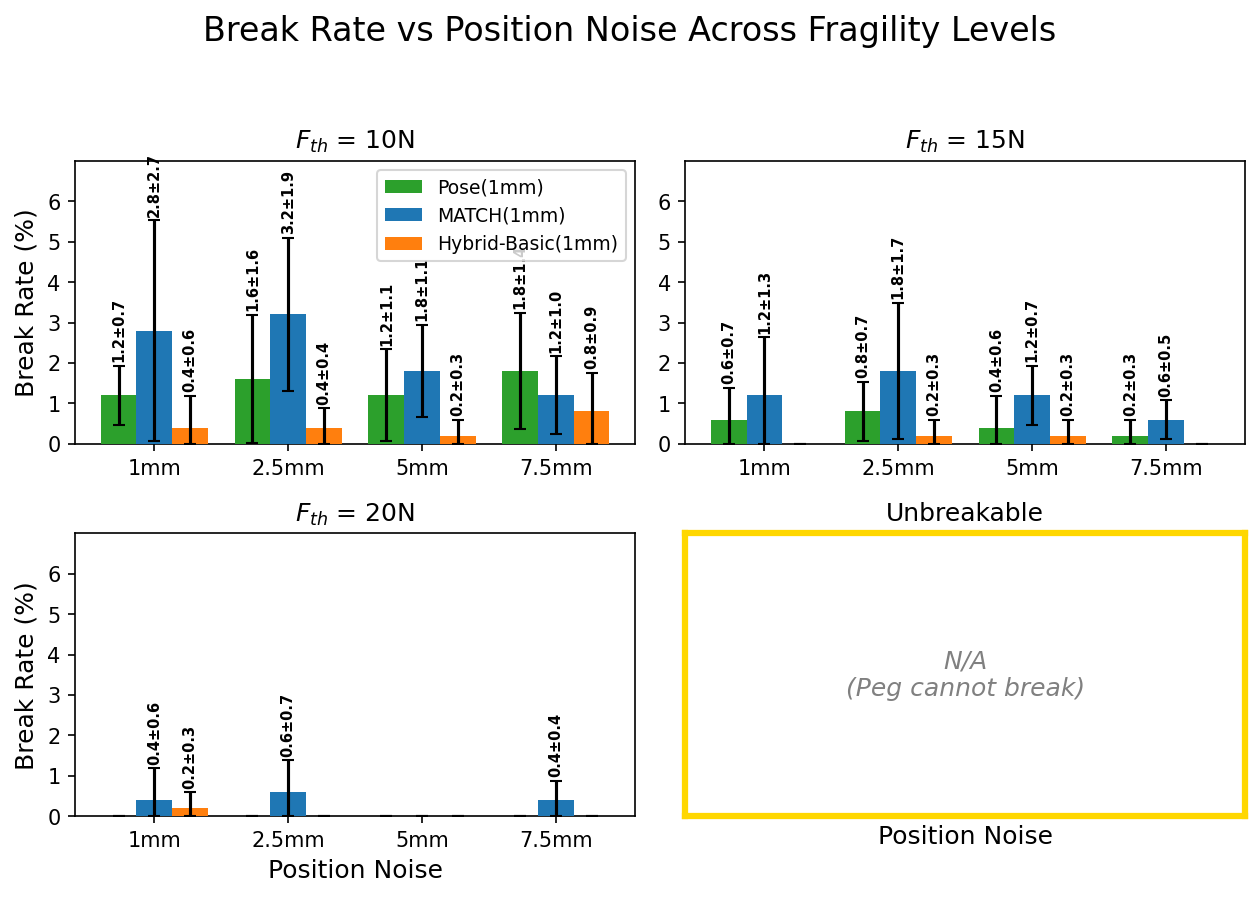

In [46]:
# ============================================================
# BLOCK 5: BREAK RATE COMPARISON FIGURE
# ============================================================

fig, axes = plot_multi_panel_grid(
    data=dict(noise_data),
    panel_keys=list(FRAGILITY_LEVELS.keys()),
    panel_display_names=FRAGILITY_DISPLAY_NAMES,
    method_names=method_names,
    level_labels=list(NOISE_LEVELS.keys()),
    level_col="noise_level",
    metric="breaks",
    n_cols=2,
    suptitle="Break Rate vs Position Noise Across Fragility Levels",
    x_label="Position Noise",
    y_label="Break Rate (%)",
    y_lim=BREAK_Y_LIM,
    y_ticks=BREAK_Y_TICKS,
    error_type=ERROR_TYPE,
    highlight_panel=HIGHLIGHT_FRAGILITY,
    na_panels=NA_FRAGILITIES,
    na_text="N/A\n(Peg cannot break)",
    filter_top_n=TOP_N_POLICIES,
    best_checkpoints=dict(best_checkpoints),
)
plt.show()